## <h1> **`Singular Value Decomposition`** </h1>  
  
This notebook contains two versions of a SVD based recommender system. The first one is the normal SVD, which uses matrix factorization to predict ratings. And secondly a SVD++ system is made, which also takes in user and item biases. Both systems will be compared in this notebook. Finally the analysis of both recommender system is done using both the Movielens and Netflix datasets.
  
**Contents**
1) Introduction
2) SVD
3) SVD Evaluation (Netflix & Movielens)
4) SVD++
5) SVD++ Evaluation (Netflix & Movielens)
6) Final Conclusion
  
Datasets: MovieLens, Netflix

------------------------------

#### **Introduction**

On October 2nd, 2006 Netflix began a contest to find a more accurate movie recommendation system to replace their current system. They promised a prize of of one million dollors to anyone who could improve over their old system with at least 10% Root Mean Squared error (RSME). After three years of the contents, the grand prize was awarded to a team using Singular Value Decomposition. In this notebook we will dive into SVD and SVD++ and we will evaluate the performances. 

But what is SVD?
SVD decomposes a matrix into three other matricces, which when multiplied together, reconstruct the original matrix. These three matrices are:

1) U: left singular vectors matrix
This represents the relationship between the rows of the original matrix. The columns are perpendicular to each other and have a length of 1. U is of dimension MxM, where m is the number of rows in the original matrix. 

2) Σ (sigma): diagonal matrix of singular values
This is a diagonal matrix containing the singular values of the original matrix. Σ is of dimension MxN, where M is the number of rows and N is the number of columns in the original matrix.

3) V^T (the transpose of V): right singular vectors matrix
This is the transpose of the matrix V, which represents the relationship between the columns of the original matrix. This matrix is of dimension N x N, where N is the number of columns in the original matrix. 

In this notebook we also use SVD++. This is an extension of the SVD method. While SVD focuses solely on decomposing the user-item interaction matrix and making predictions based on that decomposition, SVD++ incorporates additional information into the model to enhance its accuracy, in this case SVD++ takes into account implicit feedback. 

In the context of recommender systems, SVD can be applied to the user-item interaction matrix. This matrix represents user's ratings or preferences for different movies. The goal is to suggest a movie that users are likely to be interested in. This is what we will be doing in this notebook using SVD and SVD++. 

-----------------------

##### **Import packages**

In [1]:
#packages
import pandas as pd
import numpy as np
from scipy.linalg import sqrtm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

--------------------

##### **Load and prepare data**

In [2]:
#Data Movielens (~100.000 Rows)
ratings_ml = pd.read_csv('../Data/Movielens/ratings.csv')
movies_ml = pd.read_csv('../Data/Movielens/movies.csv')
ratings_ml.columns = ['user_id', 'movie_id', 'rating', 'timestamp']

#Data Netflix (~400.000 rows)
ratings_nf = pd.read_parquet('../Data/Netflix/NetflixSample.gzip')
ratings_nf[['user_id','movie_id']] = ratings_nf[['user_id','movie_id']].astype(int)
movies_nf = pd.read_parquet('../Data/Netflix/Netflix_movies.gzip')

In [3]:
#Split the data into train test data for movielens
train_data_ml, test_data_ml = train_test_split(ratings_ml, test_size=0.2, random_state=42)

#Split the data into train test data for Netflix
train_data_nf, test_data_nf = train_test_split(ratings_nf, test_size=0.2, random_state=42)

In [4]:
#Create a helper dictonary, for demonstration later on
title_dict = dict(zip(movies_ml['movieId'], movies_ml['title']))

-------------------------

# **Part 1: SVD**

##### **Explanation**

Now we will break down the structure of the code of the SVD recommender system: 

1. ``__init__()``:
This function inializes the SVD class. It takes three arugments: userField, itemField, and valueField, whcih represent the names of the columns in the dataset containing user Ids, item Ids, and ratings.

2. ``create_matrix()``:
This function creates a utitility matrix from the input data. Like explained before, this represents the relationship between the rows of the original matrix. It pivots the data to create a user-item interaction matrix using Pandas' pivot() function.
It creates mappings beteen between user IDs and indices, and item indices and IDs. After that this function handles missing values (NaNs) by replacing them with the mean rating of each item. At last, it substract the mean rating of each item from the corresponding entries in the matrix to center the data around zero.

3. ``fit_svd()``:
This function performs SVD on the centered utility matrix. It calculates the SVD of the matrix using NumPy's linalg.svd() fucntion. Then it selects the top k singular values and corresponding vectors to reduce the dimensionallity of the matrices. It builds the matrix using the reduced matrices and adds back the mean ratings of items to make the final predicted ratings.

4. ``recommend()``:
This function generates the recommendations for a list of users. It gets the predicted ratings for each user-item pair from the reconstructed matrix. Then it sort the items back on predicted ratings and returns the top N recommendations for each user.


##### **Recommender System**

In [8]:
class SVD:

    def __init__(self, userField, itemField, valueField):
        self.param = {}
        self.userField = userField
        self.itemField = itemField
        self.valueField = valueField
        self.set_k()

    ''' 
    args for SVD Recommender:
    userField   : The name of the column that contains user_id's
    itemField   : The name of the column that contains item_id's
    valueField  : the name of the column that contains the values (ratings)
    '''
    def set_k(self, k=20):
        self.k = k

    def create_matrix(self, data):
        #Create a utility matrix
        utility_matrix = data.pivot(index=self.userField, 
                                    columns=self.itemField,
                                    values=self.valueField)
        #Create mapping
        N = data[self.userField].nunique()
        M = data[self.itemField].nunique()
        user_list = np.unique(data[self.userField])
        item_list = np.unique(data[self.itemField])
        self.user_to_index = dict(zip(user_list, range(0, N)))
        self.index_to_item = dict(zip(range(0,M), item_list))

        #Create Matrix Operations
        '''In this section we create the matrix that will be used for the factorization. 
        We use a mask to identify and save the NaN locations in the matrix. We then reverse
        that mask to give us the items the user has not rated before, which is used later on.
        For normalization we take the mean of the items and subtract it from the ratings,
        this centralises the ratings. Later on, after the SVD operation we add the mean back in.
        '''
        matrix_array = utility_matrix.values #To array
        mask = np.isnan(matrix_array) #Get nan value mask True/False
        masked_arr = np.ma.masked_array(matrix_array, mask) #mask based on True/False
        self.predMask = ~mask #store the inverse of the mask for later recommendation (for what the user already has watched)
        item_means = np.mean(masked_arr, axis=0) #get mean of each item
        matrix = masked_arr.filled(item_means) #Replace NaN with item means
        self.item_means_tiled = np.tile(item_means, (matrix.shape[0], 1)) #2D array storing means of all items, same size

        #Remove the per item average from all entries, Nan will essentially be zero
        self.matrix = matrix - self.item_means_tiled

#SVD fit
    def fit_svd(self, k = None):
        if k is None:
            k = self.k
        #SVD magic, U and V are user and item features
        U, s, V = np.linalg.svd(self.matrix, full_matrices=False)
        s = np.diag(s)
        #next we take only K most significant features
        s = s[0:k,0:k] #Select the top K diagonal elements
        U = U[:,0:k] #Keep the first K columns of U
        V = V[0:k,:] #Keep the first K rows of V
        s_root = sqrtm(s) #Compute the square root of the diagonal matrix s
        Usk = np.dot(U, s_root) # Multiply U by the square root of s
        skV = np.dot(s_root, V) # Multiply the square root of s by V
        UsV = np.dot(Usk, skV) # Compute the reconstructed matrix UsV by multiplying Usk and skV
        self.UsV = UsV + self.item_means_tiled #we add the means back in to get final predicted ratings
        #UsV now ofcourse contains the final predicted ratings for each user-item combination
    
#Recommender   
    def recommend(self, users_list, N=10, values=True):
        # self.predmask is a mask that has True if already seen, This was a False for the Nan Mask just inversely stored
        #predMat consists of items that are not yet discovered by the user, the ones that are, are set very low
        predMat = np.ma.masked_where(self.predMask, self.UsV).filled(fill_value=-999)
        recommendations = [] #init list in which recommendations will be stored

        if values == True:
            for user in users_list:
                try:
                    user_idx = self.user_to_index[user]
                except:
                    raise Exception("Invalid User: ", user)
                top_indeces = predMat[user_idx,:].argsort()[-N:][::-1] #access entire row, sort on ratings, take N max, return indeces of columns(items)
                recommendations.append([(user, self.index_to_item[index], predMat[user_idx, index]) for index in top_indeces])
                #Above: Loop over top indeces for this user, retreive the rating for each index and store as tuple, in list

        if values == False:
            for user in users_list:
                try:
                    user_idx = self.user_to_index[user]
                except:
                    raise Exception("Invalid User:", user)
                top_indeces = predMat[user_idx,:].argsort()[-N:][::-1]
                recommendations.append([self.index_to_item[index] for index in top_indeces])
        
        return recommendations
    
#Evaluator   
    def evaluate(self, data, limit=0.5, prints=False):
        # Function to evaluate the system. additionally, helper function to tuning
        user_list = data[self.userField].unique() #get user list of input data
        if limit is not None: #if limit is set, take a limit of the test data, else everything
            user_list = user_list[:int(len(user_list) * limit)] #take portion if needed
        if prints == True: #If True output the prints for information
            print(len(user_list), f' : Users are going to be evaluted. {limit} of input data')
        predictions, targets = [], [] #init two lists to store predictions and targets
        N = data[self.itemField].nunique()-2 #predict rating for every movie, per user
        for user in user_list: #loop through the list of users to evaluate
            output = self.recommend([user], N=N, values=True) #get recommendations for user
            for rec in output: #For every recommendation
                for item in rec: # recommendation format (user, item_ID, Pred_rating )
                    actual_rating = data[(data[self.userField] == item[0]) & (data[self.itemField] == item[1])][self.valueField].values
                    if (actual_rating.size > 0 & (item[2] > 0)): #only evaluate if there is an actual rating, and a positive pred rating
                        targets.append(actual_rating[0]) #store actual rating
                        predictions.append(item[2]) #store predicted rating
        rmse = np.sqrt(mean_squared_error(predictions, targets)) #calculate RMSE
        if prints == True: #if True print the RMSE score
            print('RMSE: ', round(rmse, 3))
        else: # else output the rmse
            return rmse 
        
#Hyper-Tuner
    def hypertune(self, data, k_values=None, k_folds=5, prints=True, limit=0.5):

        '''args:
        data = input data to perform hypertune on, normally the train_data
        k_values = (list) list of k values to test for hypertune
        k_folds = Number of folds to cross validate
        Prints = Prints the output if set to True
        '''
        if k_values is None:
            k_values = [15, 20, 25] #K's to test by default, unless there is a specific input
        avg_rmse_dict = {} # Init Dict to store avg RMSE of each K
        best_k_rmse = [0,100] #Init list to store best k and corresponding rmse

        for k in k_values:
            kf = KFold(n_splits=k_folds, shuffle=True) # Init K_fold split
            rmse_scores = [] #store the rmse score for each fold
            for train_index, val_index in kf.split(data):
                train_data = data.iloc[train_index] #assign train data of fold
                val_data = data.iloc[val_index] #assign validation dat of fold
                self.create_matrix(train_data) #input train into svd
                self.fit_svd(k=k) #fit the svd model with k 
                svd_rmse = self.evaluate(val_data, limit=limit, prints=False) #Evaluate the system, get RMSE. set prints to false, we dont need them 
                rmse_scores.append(svd_rmse) #add rmse to scores for this fold cross validation
            avg_rmse = np.mean(rmse_scores) #calculate the rmse for this k features (overal folds)
            avg_rmse_dict[k] = avg_rmse #save the rmse for this k, to a dictonary
            if avg_rmse < best_k_rmse[1]: #update best parameter if rmse is better then current best
                best_k_rmse = [k, avg_rmse] #update best parameter list
                self.k = k #update best k

        if prints == True: #if prints option is true print the outcome of hypertune
            for k, avg_rmse in avg_rmse_dict.items():
                print(f"Average RMSE for k = {k} : {round(avg_rmse,3)} ")
            print(f"Best k is {best_k_rmse[0]}, with RMSE of {round(best_k_rmse[1],3)}")

##### **Example Usage**
We will now show an example usage of the recommender, to give an indication of the type of recommendations it makes. in the next section we will evaluate it futher

In [7]:
#Init the SVD recommender by giving it the correct names of the field in the data
svd = SVD('user_id', 'movie_id', 'rating')
svd.create_matrix(train_data_ml)
svd.fit_svd()

#We hypertune the model on the traindata, we set a limit as its for demonstration at this point
svd.hypertune(train_data_ml, limit=0.05, k_folds=2, prints=True)

Average RMSE for k = 15 : 0.947 
Average RMSE for k = 20 : 0.952 
Average RMSE for k = 25 : 0.976 
Best k is 15, with RMSE of 0.947


In [22]:
#As an example get some recommendations for user 6
output = svd.recommend([6])

print('Recommended Unseen Movies:')
for _, item, rating in output[0][:10]:
    movie = title_dict[item]
    print(f'{movie}'.ljust(50), round(rating,2))

Recommended Unseen Movies:
Jackass 2.5 (2007)                                 5.0
Benji the Hunted (1987)                            5.0
Madame Sousatzka (1988)                            5.0
Class, The (Klass) (2007)                          5.0
My Life as a Dog (Mitt liv som hund) (1985)        5.0
George Carlin: Jammin' in New York (1992)          5.0
Miss Sloane (2016)                                 5.0
No Way Out (1987)                                  5.0
All the Vermeers in New York (1990)                5.0
What Ever Happened to Baby Jane? (1962)            5.0


##### **Evaluation SVD (Movielens / Netflix)**

In this section we will evaluate the SVD recommender system on the movielens and netflix dataset, and compare results after. We use the evaluate function build into the recommender system for this. It compares the predicted ratings based on the train data with the actual ratings in the test data. It then calculates the RMSE between predicted and actual ratings.

In [24]:
#Evaluate on the Movielens
svd_movielens = SVD('user_id', 'movie_id', 'rating')
svd_movielens.create_matrix(train_data_ml)
svd_movielens.fit_svd()
svd.hypertune(train_data_ml, limit=0.5, k_folds=5, prints=False)

#Evaluate on Movie Lens Test Data
svd_movielens.evaluate(test_data_ml, limit=0.1, prints=True)

61  : Users are going to be evaluted. 0.1 of input data
RMSE:  0.895


In [36]:
#Evaluate on the Netflix
svd_netflix = SVD('user_id', 'movie_id', 'rating')
svd_netflix.create_matrix(train_data_nf)
svd_netflix.fit_svd()
svd.hypertune(train_data_ml, limit=0.05, k_folds=5, prints=False)

#Evaluate on Netfix Test data (smaller limit to have roughly same amount of users to test on)
svd_netflix.evaluate(test_data_nf, limit=0.05, prints=True)

 98 : Users are going to be evaluted. 0.05 of input data
RMSE:  0.936


**Findings:** The RMSE of the system on the movielens is 0.895, which is a good a result. This is not a surprise due the popularity of these system, and their presence in the top recommenders for Netflix. Based on the benchmarks set by suprise on their website as reference, their KNN gets a RMSE of 0.934 on the movielens. Which means our own made system is performing wel. The system performs slightly worse on the Netflix dataset with a RMSE of 0.936. In terms of performance the standard SVD is able to fit quite fast, around 1.1 seconds for the movielens and 8s for the netflix. We will take this as benchmark for when analysing the SVD++ system in the next section.


----------------------------

# **Part 2: SVD++**

##### **Explanation**

Now that we made a good performing SVD recommender system, we want to step it up by looking at SVD++. 

The code of the SVD++ is a little different from the SVD. We changed the following things in the code:
1. Incorporating implicit feedback and additional biases for users and items.
2. Using a different training alogirithm for optimization: Stochastic Gradient descent (SGD).
3. Using implicit feedback like user engagement with items in addition to explicit ratings.
4. Using additional regularization terms (reg_ui and reg_bi) for user and item biases (to prevent overfitting and improve generalization).
5. Including a hyperparameter tuning method (hypertune()) by selecting the best combination of hyperparameters. This feature is not available in the basic SVD since there is only 1 hyperparameter. The default parameters are based on literature.


##### **Explanation**

In [16]:
class SVD_PP:

    def __init__(self, userField, itemField, valueField):
        self.params = {}
        self.userField = userField
        self.itemField = itemField
        self.valueField = valueField
        self.set_params()

    ''' 
    args for SVD Recommender:
    userField   : The name of the column that contains user_id's
    itemField   : The name of the column that contains item_id's
    valueField  : the name of the column that contains the values (ratings)
    '''

    #Helper function to init and set params
    def set_params(self, k=2, lr=0.003, reg_all=0.5, reg_ui=0.05, reg_bi=0.05, n_epochs=50):
        '''This function sets the initial hyper parameters. The default ones are mostly based
        on literature. However, they get automatically updated after performing hyper
        parameter tuning '''

        self.params['k'] = k
        self.params['lr'] = lr
        self.params['reg_all'] = reg_all
        self.params['reg_ui'] = reg_ui
        self.params['reg_bi'] = reg_bi
        self.params['n_epochs'] = n_epochs

    def create_matrix(self, data):
        '''This function creates mapping dictonaries to ensure, correct
        access from id to index and vice versa. Both for users and items.
        This is done as id's are not longer part of the data when it becomes
        an array. Then its based on indices only.
        '''
        #Create a utility matrix
        utility_matrix = data.pivot(index=self.userField, 
                                    columns=self.itemField,
                                    values=self.valueField)
        #Create mapping
        N = data[self.userField].nunique()
        M = data[self.itemField].nunique()
        user_list = np.unique(data[self.userField])
        item_list = np.unique(data[self.itemField])
        self.user_to_index = dict(zip(user_list, range(0, N)))
        self.index_to_item = dict(zip(range(0,M), item_list))

        #Create Matrix Operations
        '''In this section we create the matrix that will be used for the factorization. 
        We use a mask to identify and save the NaN locations in the matrix. We then reverse
        that mask to give us the items the user has not rated before, which is used later on.
        For normalization we take the mean of the items and subtract it from the ratings,
        this centralises the ratings, the same process is used for the normal SVD. Later on, after
        the SVD operation we add the mean back in.
        '''

        matrix_array = utility_matrix.values #To array
        self.max_value = np.nanmax(matrix_array[(matrix_array != 0) & (~np.isnan(matrix_array))]) #get max value for later
        self.min_value = np.nanmin(matrix_array[(matrix_array != 0) & (~np.isnan(matrix_array))]) #get min value for later
        mask = np.isnan(matrix_array) #Get nan value mask True/False
        masked_arr = np.ma.masked_array(matrix_array, mask) #mask based on True/False
        self.predMask = ~mask #store the inverse of the mask for later recommendation (for what the user already has watched)
        item_means = np.mean(masked_arr, axis=0) #get mean of each item
        matrix = masked_arr.filled(0) #Replace NaN with 0 (instead of means as done with normal SVD)
        self.item_means_tiled = np.tile(item_means, (matrix.shape[0], 1)) #2D array storing means of all items, same size

        #Remove the per item average from all entries, Nan will essentially be zero
        self.matrix = matrix - self.item_means_tiled

#SVD fit
    def sigmoid(self, x): #Sigmoid helper function for user and item biases.
        return 1 / (1 + np.exp(-x))

    def fit(self, k=None, lr=None, reg_all=None, reg_ui=None, reg_bi=None, n_epochs=None, get_params=True):
        
        if get_params == True: #Take the stored params and not the input
            k = self.params['k']    
            lr = self.params['lr']
            reg_all = self.params['reg_all']
            reg_ui = self.params['reg_ui']
            reg_bi = self.params['reg_bi']
            n_epochs = self.params['n_epochs']

        num_users, num_items = self.matrix.shape # Get dimensions
        U = np.random.normal(scale=1. / k, size=(num_users, k)) # Init user latent factor matrix
        V = np.random.normal(scale=1. / k, size=(num_items, k)) # init item latent factor matrix
        bu = np.zeros(num_users) # Initialize user bias to zero
        bi = np.zeros(num_items) # Initialize item bias to zero
        mu = np.mean(self.matrix[np.where(self.matrix != 0)]) #Calc global mean

        for epoch in range(n_epochs): #Iterate over epochs
            for i in range(num_users): #Iterate over users
                
                ''' The error computation, bias and latent feature updates are vectorized,
                this fits the model 8 times faster then explicitly looping over users and items.
                Operations are calculated on entire matrices, which is more efficient, while maintaining
                the same RMSE results '''

                idx_items_rated_by_user = np.where(self.matrix[i, :] > 0)[0] # Select non zero indices
                if len(idx_items_rated_by_user) == 0:
                    continue  # Skip if the user hasn't rated any items
                U_i = U[i, :] # Extract latent factors 
                bu_i = bu[i] # Extract biases
                for j in idx_items_rated_by_user:
                    V_j = V[j, :] # Extract for current item
                    bi_j = bi[j] # Extract for current item
                    prediction = mu + self.sigmoid(bu_i) + self.sigmoid(bi_j) + np.dot(U_i, V_j) #Calc predictions Vectorized
                    eij = self.matrix[i, j] - prediction # Error computation vectorized

                    # Update biases and latent factors
                    bu[i] += lr * (eij - reg_all * self.sigmoid(bu_i) - reg_ui * bu_i) # Vectorized bias update for user
                    bi[j] += lr * (eij - reg_all * self.sigmoid(bi_j) - reg_bi * bi_j) # Vectorized bias update for item
                    U[i, :] += lr * (eij * V_j - reg_all * U_i) # Vectorized latent factor update for user
                    V[j, :] += lr * (eij * U_i - reg_all * V_j) # Vectorized latent factor update for item

        # Reconstruct ratings matrix
        '''Here we recompose the matrix again, but this time we add the item and user
        biases on top the the factorized matrix.
        '''          
        bu_matrix = np.tile(bu, (num_items, 1)).T
        bi_matrix = np.tile(bi, (num_users, 1)) 
        ratings_matrix = mu + self.sigmoid(bu_matrix) + self.sigmoid(bi_matrix) + np.dot(U, V.T) # Vectorized reconstruction of ratings matrix
        self.prediction_ratings = ratings_matrix + self.item_means_tiled # Add means back in for final predictions
        self.prediction_ratings = np.clip(self.prediction_ratings, self.min_value, self.max_value)

  #Recommender   
    def recommend(self, users_list, N=10, values=True):
        # self.predmask is a mask that has True if already seen, This was a False for the Nan Mask just inversely stored
        #predMat consists of items that are not yet discovered by the user, the ones that are, are set very low
        predMat = np.ma.masked_where(self.predMask, self.prediction_ratings).filled(fill_value=-999)
        recommendations = [] #init list in which recommendations will be stored

        if values == True:
            for user in users_list:
                try:
                    user_idx = self.user_to_index[user]
                except:
                    raise Exception("Invalid User: ", user)
                top_indeces = predMat[user_idx,:].argsort()[-N:][::-1] #access entire row, sort on ratings, take N max, return indeces of columns(items)
                recommendations.append([(user, self.index_to_item[index], predMat[user_idx, index]) for index in top_indeces])
                #Above: Loop over top indeces for this user, retreive the rating for each index and store as tuple, in list

        if values == False:
            for user in users_list:
                try:
                    user_idx = self.user_to_index[user]
                except:
                    raise Exception("Invalid User:", user)
                top_indeces = predMat[user_idx,:].argsort()[-N:][::-1]
                recommendations.append([self.index_to_item[index] for index in top_indeces])
        
        return recommendations
    
#Evaluator   
    def evaluate(self, data, limit=None, N=100, prints=False):
        # Function to evaluate the system. additionally, helper function to tuning
        user_list = data[self.userField].unique() #get user list of input data
        if limit is not None: #if limit is set, take a limit of the test data, else everything
            user_list = user_list[:int(len(user_list) * limit)] #take portion if needed
        if prints == True: #If True output the prints for information
            print(len(user_list), f' : Users are going to be evaluted. {limit} of input data')
        predictions, targets = [], [] #init two lists to store predictions and targets
        N = data[self.itemField].nunique()-2 #predict rating for every movie, per user
        for user in user_list: #loop through the list of users to evaluate
            output = self.recommend([user], N=N, values=True) #get recommendations for user
            for rec in output: #For every recommendation
                for item in rec: # recommendation format (user, item_ID, Pred_rating )
                    actual_rating = data[(data[self.userField] == item[0]) & (data[self.itemField] == item[1])][self.valueField].values
                    if (actual_rating.size > 0 & (item[2] > 0)): #only evaluate if there is an actual rating, and a positive pred rating
                        targets.append(actual_rating[0]) #store actual rating
                        predictions.append(item[2]) #store predicted rating
        rmse = np.sqrt(mean_squared_error(predictions, targets)) #calculate RMSE #add failsafe for when pred or targ is 0
        if prints == True: #if True print the RMSE score
            print('RMSE: ', round(rmse, 3))
        else: # else output the rmse
            return rmse 
        
#Hyper-Tuner

    def hypertune(self, data, input=None, k_folds=5, prints=True, limit=0.5):
            
        """
        Tunes hyperparameters for the SVD++ model using grid search (default).

        Args:
            data (object): Training data in a suitable format for the SVD++ model.
            input (dict, optional): Dictionary containing hyperparameters to tune.
            k_folds (optional): Number of folds for cross-validation. Defaults to 5.
            prints (optional): Whether to print hyperparameter evaluation results. Defaults to True.
            limit (optional): Limit the test size for faster hypertune.

        Returns:
            dict: Best hyperparameter configuration and corresponding performance metric.
        """

        if input is None:
            k_values = [3,5,10]
            lr_values = [0.05]
            reg_all_values =  [0.1]
            reg_ui_values = [0.05]
            reg_bi_values = [0.05]
            n_epochs_values = [20,30,50]
                
        avg_rmse_list = [] # Init Dict to store avg RMSE of each K
        best_rmse = 999 #Init to store best k and corresponding rmse

        for k in k_values:
            for lr in lr_values:
                for reg_all in reg_all_values:
                    for reg_ui in reg_ui_values:
                        for reg_bi in reg_bi_values:
                            for n_epochs in n_epochs_values:
                                rmse_scores = [] #list to store the rmse score of each fold

                                #Initialize KFold object inside the loop
                                kf = KFold(n_splits=k_folds, shuffle=True)

                                for train_index, val_index in kf.split(data):
                                    train_data = data.iloc[train_index]  # Assign train data of fold
                                    val_data = data.iloc[val_index]  # Assign validation data of fold

                                    # Create and fit the SVD++ model with current hyperparameters
                                    self.create_matrix(train_data)  # Input train into SVD++
                                    self.fit(k=k, lr=lr, reg_all=reg_all, reg_ui=reg_ui, reg_bi=reg_bi, n_epochs=n_epochs,get_params=False)

                                    rmse = self.evaluate(val_data, limit=limit, prints=False)  # Evaluate, set prints to false
                                    rmse_scores.append(rmse)

                                avg_rmse = np.mean(rmse_scores)  # Calculate avg score for all folds, for this hyper combination
                                avg_rmse_list.append(avg_rmse)

                                # Update best parameters if RMSE is better
                                if avg_rmse < best_rmse:
                                    best_rmse = avg_rmse
                                    best_params = {'k': k, 'learning_rate': lr, 'reg_all': reg_all,
                                                'reg_ui':reg_ui, 'reg_bi':reg_bi, 'n_epochs':n_epochs}
                                    self.params = {'k': k, 'lr': lr, 'reg_all': reg_all,
                                                'reg_ui':reg_ui, 'reg_bi':reg_bi, 'n_epochs':n_epochs}
        
        if prints == True:
            print(f"Best RMSE: {round(best_rmse,3)}")
            print("Best Parameters:")
            for param, value in best_params.items():
                print(f"{param}: {value}")


##### **Example Usage Hypertuning**

As with the normal SVD, this system is able to give recommendations for a particular user. This will be shown in the example usage below, in which we show the functionality of the system, hypertune it, and get recommendations for the user. Just as with the normal svd we do this on the movielens data for demonstration. the next section will evaluate the accuracy of the system on both datasets.

In [6]:
#init the system
svd_pp = SVD_PP('user_id', 'movie_id', 'rating')
svd_pp.create_matrix(train_data_ml)
svd_pp.fit()

#hypertune the system
svd_pp.hypertune(train_data_ml, limit=0.05, k_folds=2, prints=True)

Best RMSE: 1.207
Best Parameters:
k: 3
learning_rate: 0.05
reg_all: 0.1
reg_ui: 0.05
reg_bi: 0.05
n_epochs: 50


In [8]:
#As an example get some recommendations for user 6
output = svd_pp.recommend([6])

print('Recommended Unseen Movies:')
for _, item, rating in output[0][:10]:
    movie = title_dict[item]
    print(f'{movie}'.ljust(50), round(rating,2))

Recommended Unseen Movies:
Strictly Sexual (2008)                             4.93
00 Schneider - Jagd auf Nihil Baxter (1994)        4.78
12 Chairs (1976)                                   4.77
Junior and Karlson (1968)                          4.61
Shaft (1971)                                       4.6
Palindromes (2004)                                 4.6
Godfather, The (1972)                              4.58
Tickling Giants (2017)                             4.58
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) 4.56
The Eye: Infinity (2005)                           4.55


##### **Evaluation SVD++ (Movielens / Netflix)**

In this section we will evaluate the SVD++ recommender system on the movielens and netflix dataset, and compare results after. We use the evaluate function build into the recommender system for this. It compares the predicted ratings based on the train data with the actual ratings in the test data. It then calculates the RMSE between predicted and actual ratings.

In [11]:
#Evaluate on the Movielens
svd_pp_movielens = SVD_PP('user_id', 'movie_id', 'rating')
svd_pp_movielens.create_matrix(train_data_ml)
svd_pp_movielens.fit()
svd_pp_movielens.hypertune(train_data_ml, limit=0.5, k_folds=5, prints=False)

#Evaluate on Movie Lens Test Data
svd_pp_movielens.evaluate(test_data_ml, limit=0.1, prints=True)

61  : Users are going to be evaluted. 0.1 of input data
RMSE:  0.946


In [15]:
#Evaluate on the Movielens
svd_pp_netflix = SVD_PP('user_id', 'movie_id', 'rating')
svd_pp_netflix.create_matrix(train_data_nf)
svd_pp_netflix.fit()
svd_pp_movielens.hypertune(train_data_ml, limit=0.5, k_folds=5, prints=False)

#Evaluate on Movie Lens Test Data
svd_pp_netflix.evaluate(test_data_nf, limit=0.05, prints=True)

98 : Users are going to be evaluted. 0.05 of input data
RMSE:  0.994


**Findings:** To our suprise the SVD++ system performs a bit worse then the normal SVD system. However, we should note that not a very wide range of possible hyper tune combinations was used, and it was also done on a limited data, due to computational and time constraints. This will most likely improve the system further.However, this could also be viewed as a benefit of using the normal SVD as training and hypertuning the model takes less resources. The fitting of the SVD++ model also takes longer, due to the gradient descent. Both models once trained are very fast, and capable of seemingly instantly giving recommendations for both datasets for a user. The SVD++ besides from proper hyperparameter tuning, could be further improved by incorperating the timestamp, making it a timesvd++ model.

------------------------------

#### **Conclusion**

We can conclude that the SVD on the MovieLens dataset performs best with an RMSE of 0.9. This is unexpected since we thought that the SVD++ would perform better than the normal SVD, since it incorporates more information to make the recommendation. Another reason could be that the complexity introduced to the additional parameters in SVD++ could lead to overfitting. This is particularly the case in scenarios with limited data. This could have led to the SVD++ performing less than the SVD. 

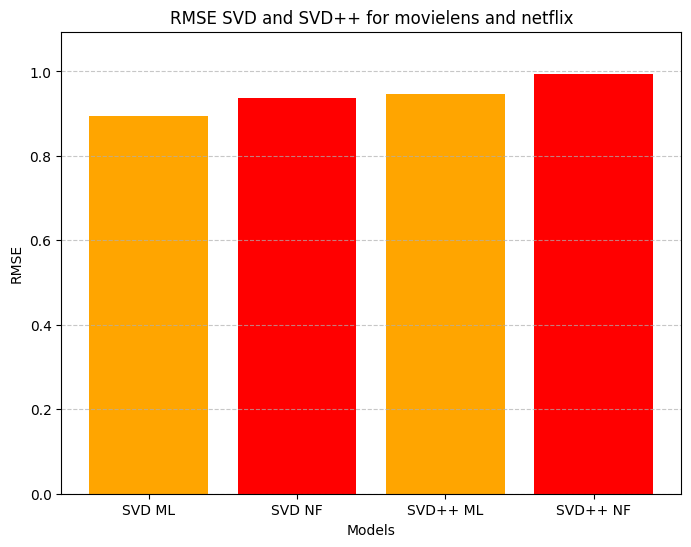

In [21]:
import matplotlib.pyplot as plt

# RMSE values for SVD and SVD++
svd_rmse_ml = 0.895  
svd_rmse_nf = 0.936
svd_pp_rmse_ml = 0.946
svd_pp_rmse_nf = 0.994  

# Names of the models
models = ['SVD ML', 'SVD NF', 'SVD++ ML', 'SVD++ NF']

# RMSE values
rmse_values = [svd_rmse_ml, svd_rmse_nf,svd_pp_rmse_ml,svd_pp_rmse_nf]

# Create bar plot
plt.figure(figsize=(8, 6))
plt.bar(models, rmse_values, color=['orange', 'red'])
plt.title('RMSE SVD and SVD++ for movielens and netflix')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.ylim(0, max(rmse_values) + 0.1)  # Adjust ylim for better visualization
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
